Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---


# Model Interpretation 2

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make a Shapley force plot to explain at least 1 individual prediction.
- [ ] Share at least 1 visualization (of any type) on Slack.

But, if you aren't ready to make a Shapley force plot with your own dataset today, that's okay. You can practice this objective with another dataset instead. You may choose any dataset you've worked with previously.

## Stretch Goals
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!


## Links
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
import pandas as pd
df = pd.read_csv('Main_Data.csv')

In [0]:
# Removeing others values
df = df[df.decision != 'Others']
df = df.replace({'Accepted':1, 'Rejected':0})

In [0]:
df = df.dropna()

In [0]:
df = df.reset_index()

In [0]:
df = df.rename(columns={'index':'student_req_id'})

In [0]:
df.head()

,student_req_id,comment,major,gre_quant,degree,season,decision,gre_verbal,date_of_result,term_year,undergrad_gpa,date_added,applicant_status,university,gre_awa
0,12,TOEFL: 106/120,"Computer Science,",159.0,Masters,Spring,1,150.0,2019-07-05,2020,3.68,2019-07-22,International without US degree,Georgia Institute Of Technology,4.0
1,24,"Forgot to update, But got rejected without wai...","Computer Science,",170.0,PhD,Fall,0,159.0,2019-07-03,2019,3.90,2019-07-03,International without US degree,Iowa State University,5.0
2,41,"From very good Italian Polytechnic Uni, with a...","Computer Science,",164.0,Masters,Fall,1,158.0,2019-06-20,2019,3.75,2019-06-20,International without US degree,EPFL,3.5
3,98,Waitlisted and then rejected.,"Computer Science,",168.0,PhD,Fall,0,149.0,2019-05-27,2019,3.86,2019-05-27,International without US degree,University Of Toronto,3.0
4,104,TTPB: Who had asked about UT Austin acceptance...,"Computer Science,",167.0,Masters,Fall,0,159.0,2019-05-25,2019,3.81,2019-05-25,International with US degree,McGill University,5.0


In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,test_size=0.2,
                               stratify=df['decision'],
                               random_state=59)

train, val = train_test_split(train, test_size=0.25,
                              stratify=train['decision'],
                              random_state=59)
train.shape, val.shape, test.shape

((426415, 15), (142139, 15), (142139, 15))

In [0]:
test_id = test.student_req_id

In [0]:
# Baseline

from sklearn.metrics import accuracy_score
y_pred = [1] * len(df['decision'])
accuracy_score(df['decision'], y_pred)

0.5612310800866197

In [0]:
df.columns

Index(['student_req_id', 'comment', 'major', 'gre_quant', 'degree', 'season',
       'decision', 'gre_verbal', 'date_of_result', 'term_year',
       'undergrad_gpa', 'date_added', 'applicant_status', 'university',
       'gre_awa'],
      dtype='object')

In [0]:
def wrangle(X):
# Wrangle train, validate, and test sets
    
    # Prevent SettingWithCopyWarning (in acordince with lectuere)
    X = X.copy()
  
    #X = X.drop(columns=['gre_awa'])
      # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# creating target and features lsts
target = 'decision'
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features = numeric_features + categorical_features
print(features)

['student_req_id', 'gre_quant', 'gre_verbal', 'term_year', 'undergrad_gpa', 'gre_awa', 'degree', 'season', 'applicant_status']


In [0]:
# creating Train, Validation, and Test vars
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=350, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
#pipeline.fit(X_train, y_train)
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.849246160448575


In [0]:
# This ROC score worrys me 
scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='roc_auc')
print('Validation ROC AUC:', scores)

Validation ROC AUC: [0.95825791 0.95796484 0.95851815]


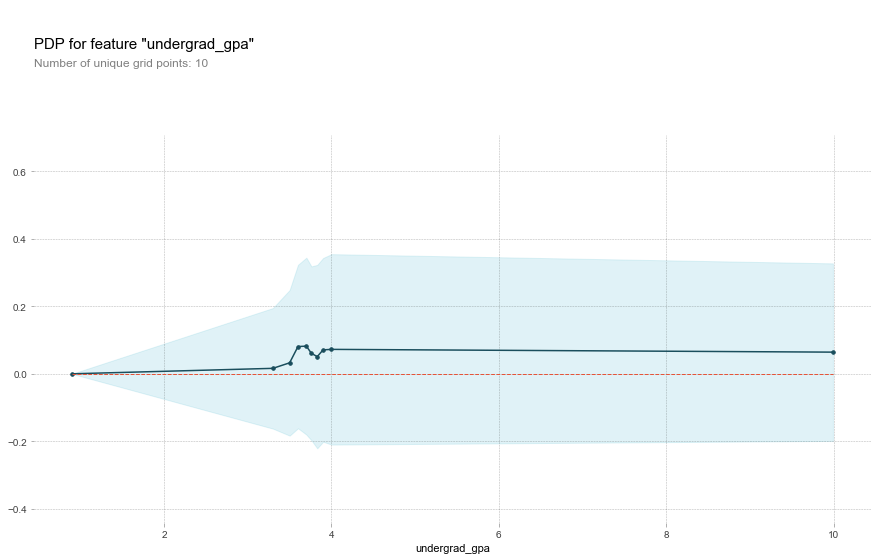

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'undergrad_gpa'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

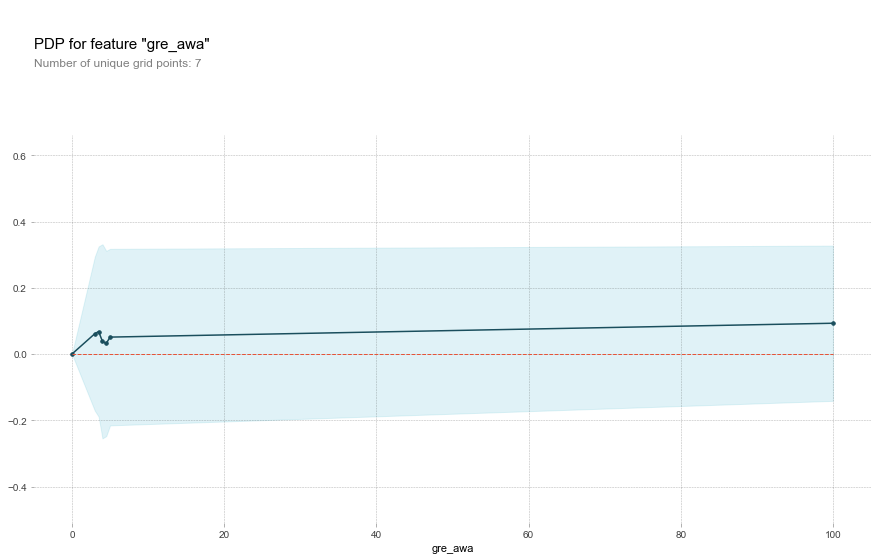

In [0]:
feature = 'gre_awa'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

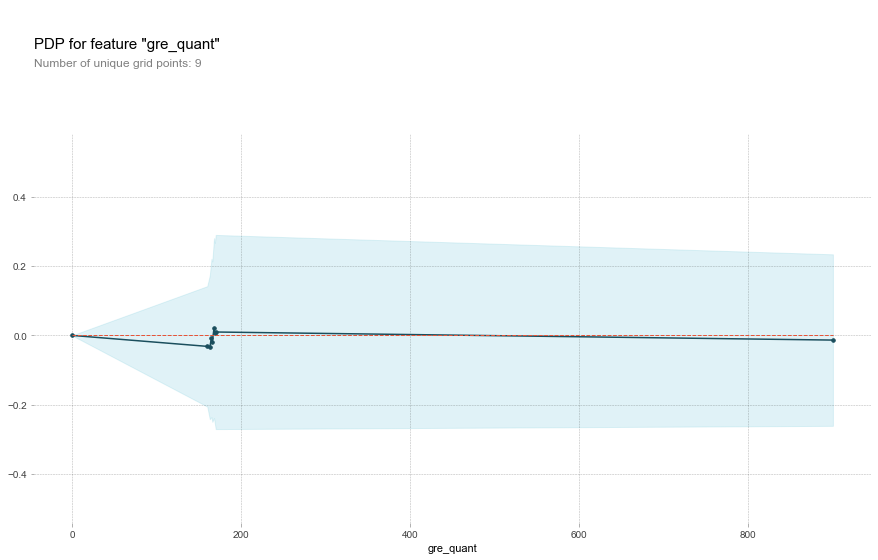

In [0]:
feature = 'gre_quant'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

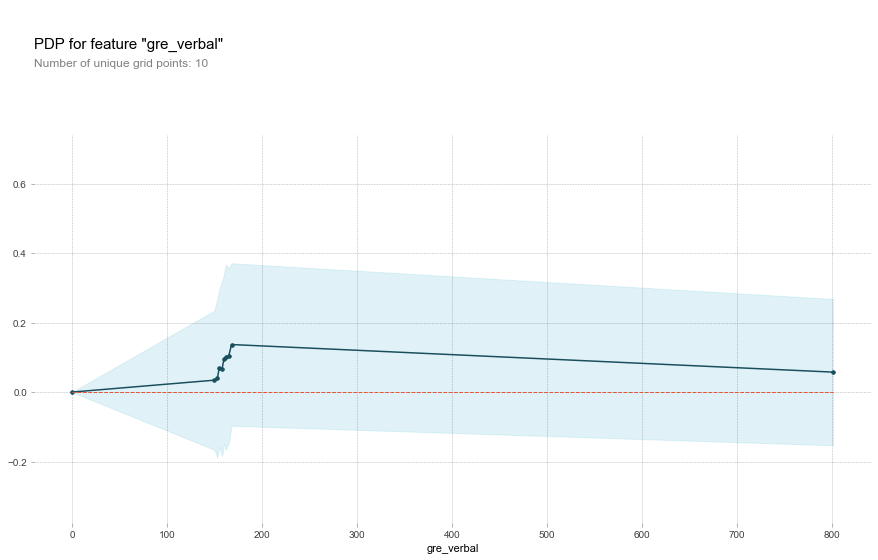

In [0]:
feature = 'gre_verbal'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

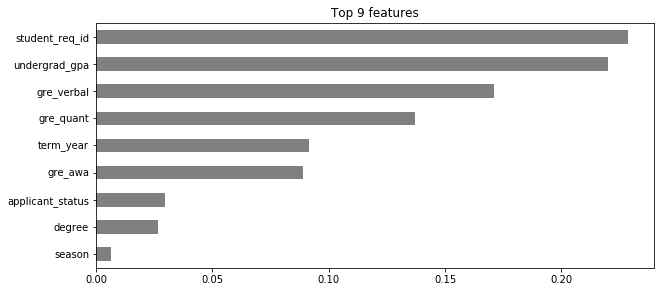

In [0]:
# Get feature importances

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 9

plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
gb = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

C:\Users\riley\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\riley\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Gradient Boosting R^2 0.11809727392867075


In [0]:
# Get the permutation importance
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [0]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

undergrad_gpa       0.171517
gre_verbal          0.160252
gre_quant           0.107416
term_year           0.106382
applicant_status    0.104250
degree              0.073763
gre_awa             0.065679
season              0.003906
student_req_id     -0.039701
dtype: float64

In [0]:
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.1715 ± 0.0011,undergrad_gpa
0.1603 ± 0.0013,gre_verbal
0.1074 ± 0.0006,gre_quant
0.1064 ± 0.0013,term_year
0.1043 ± 0.0020,applicant_status
0.0738 ± 0.0009,degree
0.0657 ± 0.0014,gre_awa
0.0039 ± 0.0001,season
-0.0397 ± 0.0017,student_req_id


In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.580441	validation_1-auc:0.581266
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.582726	validation_1-auc:0.58354
[2]	validation_0-auc:0.589647	validation_1-auc:0.590821
[3]	validation_0-auc:0.594323	validation_1-auc:0.595433
[4]	validation_0-auc:0.594926	validation_1-auc:0.596199
[5]	validation_0-auc:0.59458	validation_1-auc:0.596066
[6]	validation_0-auc:0.595684	validation_1-auc:0.596965
[7]	validation_0-auc:0.596424	validation_1-auc:0.597656
[8]	validation_0-auc:0.5975	validation_1-auc:0.598862
[9]	validation_0-auc:0.602738	validation_1-auc:0.603841
[10]	validation_0-auc:0.607071	validation_1-auc:0.608461
[11]	validation_0-auc:0.607806	validation_1-auc:0.609301
[12]	validation_0-auc:0.609146	validation_1-auc:0.610868
[13]	validation_0-auc:0.609635	validation_1-auc:0.611283
[14]	validation_0-auc:0.612494	validation_1-auc:0.613921
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba))

Test ROC AUC for class 1:
0.8008824067610705


In [0]:
df_with_pred = pd.DataFrame({
    'student_req_id': test_id, 
    'pred_proba': y_pred_proba, 
    'decision': y_test
})

df_with_pred = df_with_pred.merge(
     test[['student_req_id', 'comment', 'major', 'gre_quant', 'degree', 'season', 'decision',
       'gre_verbal', 'date_of_result', 'term_year', 'undergrad_gpa',
       'date_added', 'applicant_status', 'university', 'gre_awa']], 
     how='left'
)

In [0]:
# Making easy filters
cpass = df_with_pred['decision'] == 0
cfail = df_with_pred['decision'] == 1
right = (cpass) == (df_with_pred['pred_proba'] > 0.50)
wrong = ~right

In [2]:
df_with_pred = df_with_pred['decision'].repplace({1: 'yes',0 : 'no'})

NameError: ignored